In [3]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
import numpy as np
from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score, recall_score, precision_score, average_precision_score, f1_score, classification_report, accuracy_score, plot_roc_curve, plot_precision_recall_curve, ConfusionMatrixDisplay, confusion_matrix

In [6]:
import mysql_connector_ssh_rsa

In [7]:
Con = mysql_connector_ssh_rsa.Connector

In [8]:
query = 'select * from `es-orders`.orders'
df = Con.mysql_connect(query)

In [73]:
# df_filter = df[(df.status_id == 'DELETE') | (df.status_id == 'DONE')]
df_filter = df[(df.status_id == 'DONE')]
# df_filter = df_filter[df.distance > 1500]

In [74]:
df_date = df_filter
df_date.status_id = df_filter.status_id.map({'DONE': 1, 'DELETE': 0})

In [ ]:
df_date = df_date[df_date.date < '2022-11-07 14:00:00']
df_date = df_date[df_date.status_id == 1]
df_date.info()

In [ ]:
print(type(df_date.loc[5]['date']))
print(df_date.loc[5]['date'].date())

In [77]:
df_date['date'] = df_date['date'].dt.date

In [ ]:
# df_date['count'] = sm.add_constant(1)
df_date.head()

In [ ]:
df_date1 = df_date.groupby('date')['count'].count()
df_date1

In [ ]:
df_date1.plot(kind='line', x='date', y='count')

In [827]:
# df_filter = df_filter[df.cargo_count < 3]

In [ ]:
df_filter.groupby('is_individual_calc')['status_id'].count()

In [844]:
# df_research = df_filter[['status_id', 'total', 'distance', 'distance_feed', 'distance_return', 'cargo_count', 'is_individual_calc', 'source_id', 'payment_method']]
df_research = df_filter[['status_id', 'total', 'distance_feed', 'distance_return', 'cargo_count', 'is_individual_calc', 'communication_method', 'payment_method', 'duration', 'distance_out_of_city', 'paid_by_cash', 'discount', 'tariff_param_id']]

In [845]:
df_research.status_id = df_research.status_id.map({'DONE': 1, 'DELETE': 0})

In [834]:
df_filter.status_id.unique()

array([1, 0])

In [846]:
df_dummy = pd.get_dummies(df_research, columns=['cargo_count', 'is_individual_calc', 'communication_method', 'payment_method', 'duration',  'tariff_param_id', 'discount'], drop_first=True)

In [ ]:
numeric_cols = ['total', 'distance_feed', 'distance_return', 'distance_out_of_city', 'paid_by_cash' ]
cat_cols = list(set(df_dummy.columns) - set(numeric_cols) - {'status_id'})
cat_cols.sort()

print(numeric_cols)
print(cat_cols)

In [ ]:
random_seed = 888
# df_train, df_test = train_test_split(df_dummy, test_size=0.80, random_state=random_seed, stratify=df_dummy['status_id'])
df_train, df_test = df_dummy, df_dummy

print(df_dummy.shape)
print(df_train.shape)
print(df_test.shape)
print()
print(df_dummy['status_id'].value_counts(normalize=True))
print()
print(df_train['status_id'].value_counts(normalize=True))
print()
print(df_test['status_id'].value_counts(normalize=True))

In [849]:
# Преобразуем возраст в скалярную величину
scaler = StandardScaler()
scaler.fit(df_dummy[numeric_cols])

StandardScaler()

In [850]:
def get_features_and_target_arrays(df, numeric_cols, cat_cols, scaler):
    X_numeric_scaled = scaler.transform(df[numeric_cols])
    X_categorical = df[cat_cols].to_numpy()
    X = np.hstack((X_categorical, X_numeric_scaled))
    y = df['status_id']
    return X, y

X, y = get_features_and_target_arrays(df_dummy, numeric_cols, cat_cols, scaler)

In [851]:
clf = LogisticRegression(penalty='none')
clf.fit(X, y)

LogisticRegression(penalty='none')

In [852]:
X_test, y_test = get_features_and_target_arrays(df_test, numeric_cols, cat_cols, scaler)

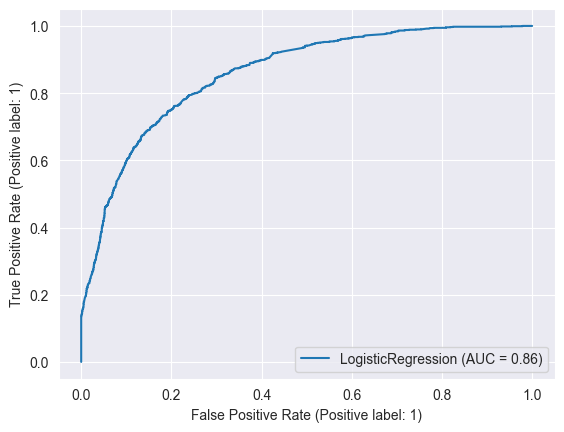

In [853]:
plot_roc_curve(clf, X_test, y_test)
plt.show()

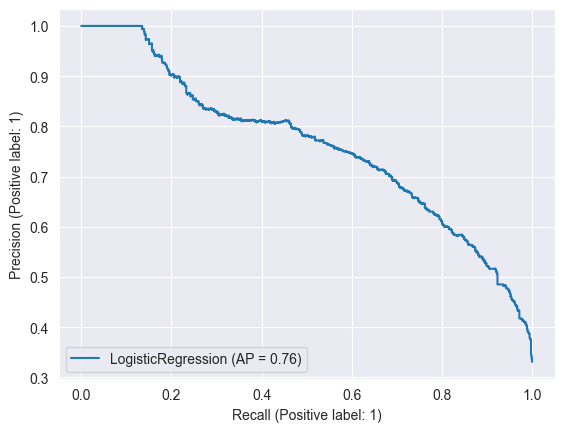

In [854]:
plot_precision_recall_curve(clf, X_test, y_test)
plt.show()

In [855]:
test_prob = clf.predict_proba(X_test)[:, 1]
test_pred = clf.predict(X_test)

In [856]:
print('Log loss = {:.5f}'.format(log_loss(y_test, test_prob)))
print('AUC = {:.5f}'.format(roc_auc_score(y_test, test_prob)))
print('Average Precision = {:.5f}'.format(average_precision_score(y_test, test_prob)))
print('\nUsing 0.5 as threshold:')
print('Accuracy = {:.5f}'.format(accuracy_score(y_test, test_pred)))
print('Precision = {:.5f}'.format(precision_score(y_test, test_pred)))
print('Recall = {:.5f}'.format(recall_score(y_test, test_pred)))
print('F1 score = {:.5f}'.format(f1_score(y_test, test_pred)))

print('\nClassification Report')
print(classification_report(y_test, test_pred))

Log loss = 0.42835
AUC = 0.85887
Average Precision = 0.76100

Using 0.5 as threshold:
Accuracy = 0.80182
Precision = 0.71233
Recall = 0.67314
F1 score = 0.69218

Classification Report
              precision    recall  f1-score   support

           0       0.84      0.87      0.85      2498
           1       0.71      0.67      0.69      1236

    accuracy                           0.80      3734
   macro avg       0.78      0.77      0.77      3734
weighted avg       0.80      0.80      0.80      3734



Confusion Matrix


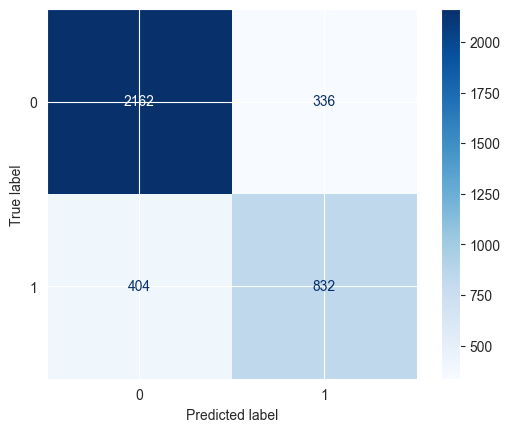

[[2162  336]
 [ 404  832]]
<class 'numpy.ndarray'>


In [857]:
print('Confusion Matrix')
conf_matrix = confusion_matrix(y_test, test_pred)
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot(cmap=plt.cm.Blues, values_format='g')
plt.show()
print(conf_matrix)
print(type(conf_matrix))

In [858]:
coefficients = np.hstack((clf.intercept_, clf.coef_[0]))
pd.DataFrame(data={'variable': ['intercept'] + cat_cols + numeric_cols, 'coefficient': coefficients})

,variable,coefficient
0,intercept,-3.346211
1,cargo_count_1,0.839665
2,cargo_count_2,0.674202
3,cargo_count_3,0.578334
4,cargo_count_4,-0.075777
5,communication_method_phone,-0.753986
6,communication_method_whatsapp,-1.096975
7,discount_1,-2.531203
8,discount_10,0.480745
9,discount_2,0.176707


In [859]:
df_dummy['status_id'].value_counts()

0    2498
1    1236
Name: status_id, dtype: int64

In [860]:
x_result = pd.DataFrame()
x_result['fact'] = df_dummy['status_id']
x_result['predict'] = test_pred
x_result['result'] = x_result.fact - x_result.predict
x_result = x_result['result'].value_counts()
x_result.index = ['Match', 'False-Negative', 'False-Positive']
x_result = pd.concat([x_result, x_result / sum(x_result)], axis=1)
x_result

,result,result
Match,2994,0.801821
False-Negative,404,0.108195
False-Positive,336,0.089984
